In [1]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [2]:
from nixtlats import TimeGPT

timegpt = TimeGPT(
    # defaults to os.environ.get("TIMEGPT_TOKEN")
    token = 'T5AJrfyJ7gocuVZTzGR6sPZ51DOtKddik2NPnxc8Fjz4b1ibkutdClGcgy74V8UYgj2KEpurpbCZ6ukKYlkwZTlIuAe5ZNTtqvyEnYMbKSWM7nLiQE6ygZB4YCW3ZQsXHtx84VLcKzeh5DdYTcBc354WCsSOeDZEzEWbOKdNVJQL9NXfezSq6H2mviGoDJWt600LUgTbRDeVQSa8TC2zsSHz8qJOACImWFCQYe781TDKDkIiFp2OEs2lfrHfjzZQ'
)


In [3]:
timegpt.validate_token()

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

In [4]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts import TimeSeries
from darts.models import NHiTSModel, TiDEModel, TFTModel, TCNModel, RNNModel
from darts.datasets import AusBeerDataset
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [5]:
import copy
from pathlib import Path

# List of columns you want to read
selected_columns = ["Timestamp [s]", "CPU usage [%]", "Memory usage [%]"]

file_path = 'VM001.csv'
df = pd.read_csv(file_path, usecols=selected_columns)

# Convert 'Timestamp [ms]' to datetime and set it as the index
df.set_index('Timestamp [s]', inplace=True)

# Specify the frequency of your time series (e.g., 'H' for hourly, 'D' for daily)
frequency = 'm'  # Replace 'your_frequency' with the appropriate frequency code

# Preserve the 'Timestamp [ms]' column
df['Timestamp [s]'] = df.index

df.head(-1)

,CPU usage [%],Memory usage [%],Timestamp [s]
Timestamp [s],,,
2013-06-30 22:03:00,0.000000,6.500000,2013-06-30 22:03:00
2013-06-30 22:04:00,0.066578,6.536489,2013-06-30 22:04:00
2013-06-30 22:05:00,0.157880,6.586528,2013-06-30 22:05:00
2013-06-30 22:06:00,0.220217,6.620693,2013-06-30 22:06:00
2013-06-30 22:07:00,0.259892,6.642437,2013-06-30 22:07:00
...,...,...,...
2013-12-13 21:53:00,5.958158,11.280959,2013-12-13 21:53:00
2013-12-13 21:54:00,6.337063,11.567609,2013-12-13 21:54:00
2013-12-13 21:55:00,7.714891,12.674611,2013-12-13 21:55:00


<Axes: xlabel='Timestamp [s]'>

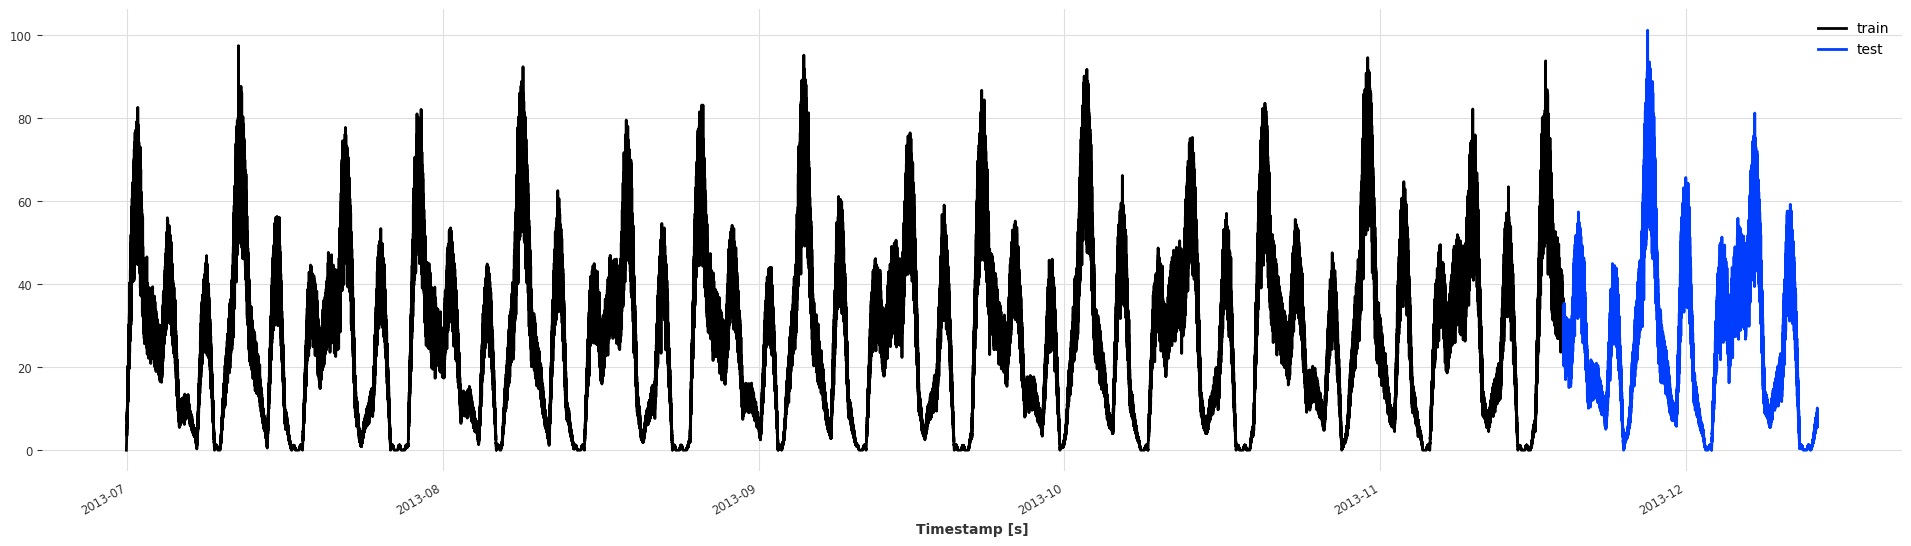

In [12]:
# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, "Timestamp [s]", 'CPU usage [%]')

train, test = series.split_after(0.85)

plt.figure(figsize=(24, 6))
train.plot(label="train")
test.plot(label="test")

In [16]:
train_df = train.pd_dataframe()
train_df['Timestamp [s]'] = train_df.index
train_df = train_df.reset_index(drop=True)

test_df = train.pd_dataframe()
test_df['Timestamp [s]'] = test_df.index
test_df = test_df.reset_index(drop=True)


train_df.head(-1)

component,CPU usage [%],Timestamp [s]
0,0.000000,2013-06-30 22:03:00
1,0.066578,2013-06-30 22:04:00
2,0.157880,2013-06-30 22:05:00
3,0.220217,2013-06-30 22:06:00
4,0.259892,2013-06-30 22:07:00
...,...,...
203174,29.894790,2013-11-19 00:17:00
203175,28.736196,2013-11-19 00:18:00
203176,29.483110,2013-11-19 00:19:00
203177,28.047599,2013-11-19 00:20:00


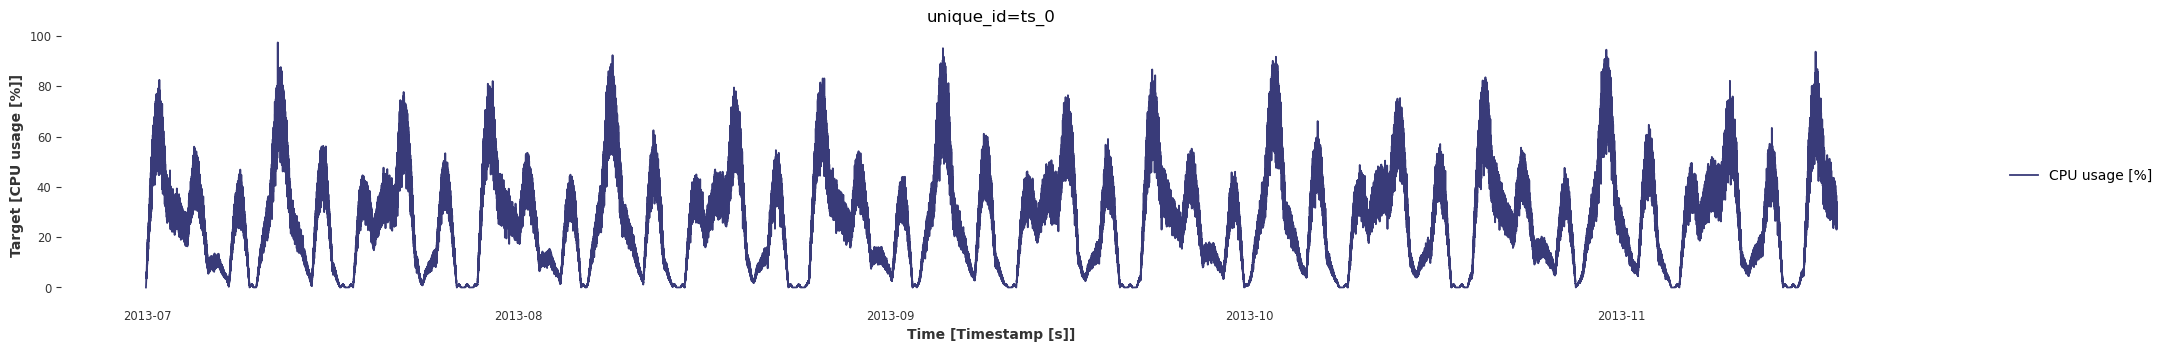

In [17]:
timegpt.plot(train_df, time_col='Timestamp [s]', target_col='CPU usage [%]')

In [19]:
timegpt_fcst_df = timegpt.forecast(df=train_df, h=5760, freq='min', time_col='Timestamp [s]', target_col='CPU usage [%]')
timegpt_fcst_df.head()

ReadTimeout: The read operation timed out